In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


In [2]:
pip install pmdarima

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Load the dataset
def load_and_preprocess(file_path):
    # Read the CSV file
    data = pd.read_csv(file_path)
    
    # Convert 'Date' column to datetime and set it as the index
    data['Date'] = pd.to_datetime(data['Date'])
    data.set_index('Date', inplace=True)
    
    # Sort the DataFrame by the 'Date' index in ascending order
    data.sort_index(inplace=True)
    
    # Clean the 'Price' column
    data['Price'] = data['Price'].astype(str).str.replace(',', '').astype(float)
    data.replace([np.inf, -np.inf], np.nan, inplace=True)
    data.dropna(subset=['Price'], inplace=True)
    
    return data

In [4]:
# Load and preprocess intel and intel datasets
intel_data = load_and_preprocess('../../Dataset/intel_stock_price.csv')

In [5]:
intel_data

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2020-12-31,49.82,48.75,50.19,48.72,28.58M,2.19%
2021-01-04,49.67,49.89,51.39,49.40,46.10M,-0.30%
2021-01-05,50.61,49.45,50.83,49.33,24.87M,1.89%
2021-01-06,51.10,50.44,52.15,50.20,36.81M,0.97%
2021-01-07,52.19,51.49,52.69,51.30,32.09M,2.13%
...,...,...,...,...,...,...
2025-04-09,21.53,18.07,21.73,17.98,224.18M,18.75%
2025-04-10,19.88,20.67,20.82,19.16,129.06M,-7.66%
2025-04-11,19.74,19.25,19.80,18.17,128.43M,-0.70%


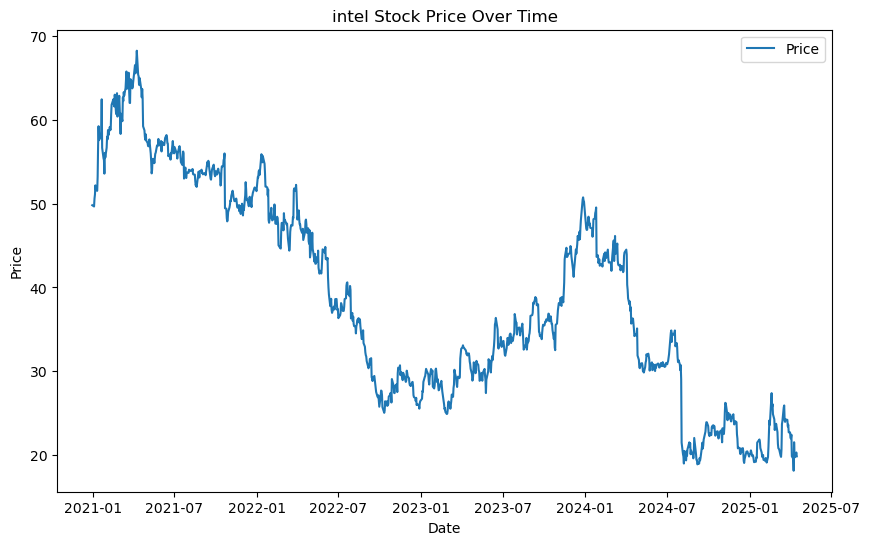

In [6]:
# Plot the 'Price' column over time
def plot_price(data, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['Price'], label='Price')
    plt.title(f'{title} Stock Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

plot_price(intel_data, 'intel')

In [7]:

# Perform stationarity test using Augmented Dickey-Fuller (ADF) test
def adf_test(series, title=''):
    print(f'Augmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna())
    labels = ['ADF Test Statistic', 'p-value', '# Lags Used', '# Observations']
    out = pd.Series(result[0:4], index=labels)
    for key, val in result[4].items():
        out[f'Critical Value ({key})'] = val
    print(out.to_string())
    if result[1] <= 0.05:
        print("Data is stationary.")
    else:
        print("Data is not stationary.")


In [8]:
print("intel Stock Price Stationarity Test:")
adf_test(intel_data['Price'], 'intel Stock Price')



intel Stock Price Stationarity Test:
Augmented Dickey-Fuller Test: intel Stock Price
ADF Test Statistic        -1.009894
p-value                    0.749639
# Lags Used                0.000000
# Observations          1076.000000
Critical Value (1%)       -3.436442
Critical Value (5%)       -2.864230
Critical Value (10%)      -2.568202
Data is not stationary.


In [9]:

# Perform differencing if data is not stationary
def make_stationary(data, column):
    data[f'Log_{column}'] = np.log(data[column])
    data[f'Log_Diff_{column}'] = data[f'Log_{column}'].diff()
    return data

In [10]:
intel_data = make_stationary(intel_data, 'Price')


In [11]:

# Re-test stationarity after differencing
print("\intel Price Stationarity Test After Differencing:")
adf_test(intel_data['Log_Diff_Price'], 'intel Stock Price After Differencing')

\intel Price Stationarity Test After Differencing:
Augmented Dickey-Fuller Test: intel Stock Price After Differencing
ADF Test Statistic       -21.678591
p-value                    0.000000
# Lags Used                1.000000
# Observations          1074.000000
Critical Value (1%)       -3.436453
Critical Value (5%)       -2.864235
Critical Value (10%)      -2.568205
Data is stationary.


In [12]:
intel_data

,Price,Open,High,Low,Vol.,Change %,Log_Price,Log_Diff_Price
Date,,,,,,,,
2020-12-31,49.82,48.75,50.19,48.72,28.58M,2.19%,3.908417,NaN
2021-01-04,49.67,49.89,51.39,49.40,46.10M,-0.30%,3.905401,-0.003015
2021-01-05,50.61,49.45,50.83,49.33,24.87M,1.89%,3.924149,0.018748
2021-01-06,51.10,50.44,52.15,50.20,36.81M,0.97%,3.933784,0.009635
2021-01-07,52.19,51.49,52.69,51.30,32.09M,2.13%,3.954891,0.021106
...,...,...,...,...,...,...,...,...
2025-04-09,21.53,18.07,21.73,17.98,224.18M,18.75%,3.069447,0.171879
2025-04-10,19.88,20.67,20.82,19.16,129.06M,-7.66%,2.989714,-0.079733
2025-04-11,19.74,19.25,19.80,18.17,128.43M,-0.70%,2.982647,-0.007067


In [13]:
# Check for missing values
print(intel_data.isnull().sum())

# Drop rows with missing values if necessary
intel_data.dropna(subset=['Log_Price', 'Log_Diff_Price'], inplace=True)

Price             0
Open              0
High              0
Low               0
Vol.              0
Change %          0
Log_Price         0
Log_Diff_Price    1
dtype: int64


In [14]:

# Plot the differenced data
def plot_differenced(data, column, title):
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data[column], label='Differenced Price')
    plt.title(f'{title} Differenced Stock Price')
    plt.xlabel('Date')
    plt.ylabel('Differenced Price')
    plt.legend()
    plt.show()


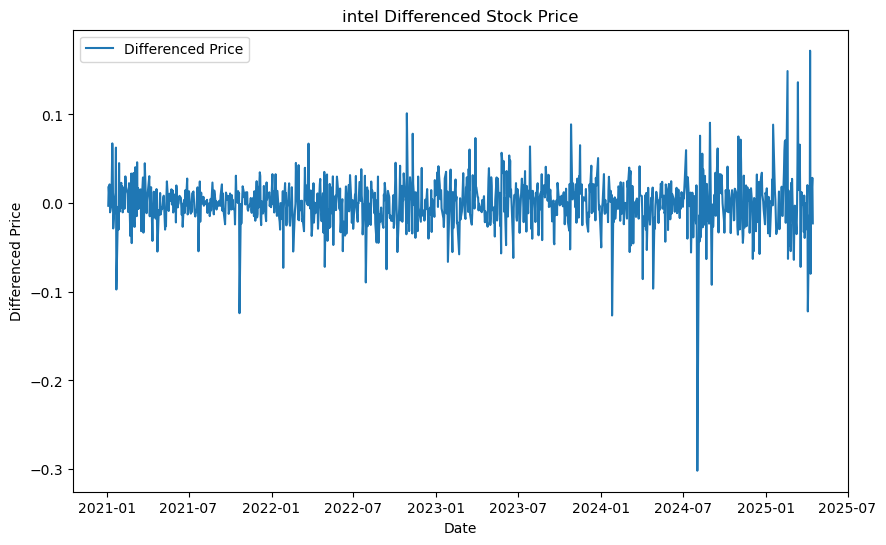

In [15]:

plot_differenced(intel_data, 'Log_Diff_Price', 'intel')

In [16]:
# Convert to Stationary Time Series
intel_data['Log_Price'] = np.log(intel_data['Price'])
intel_data['Log_Diff'] = intel_data['Log_Price'].diff().dropna()


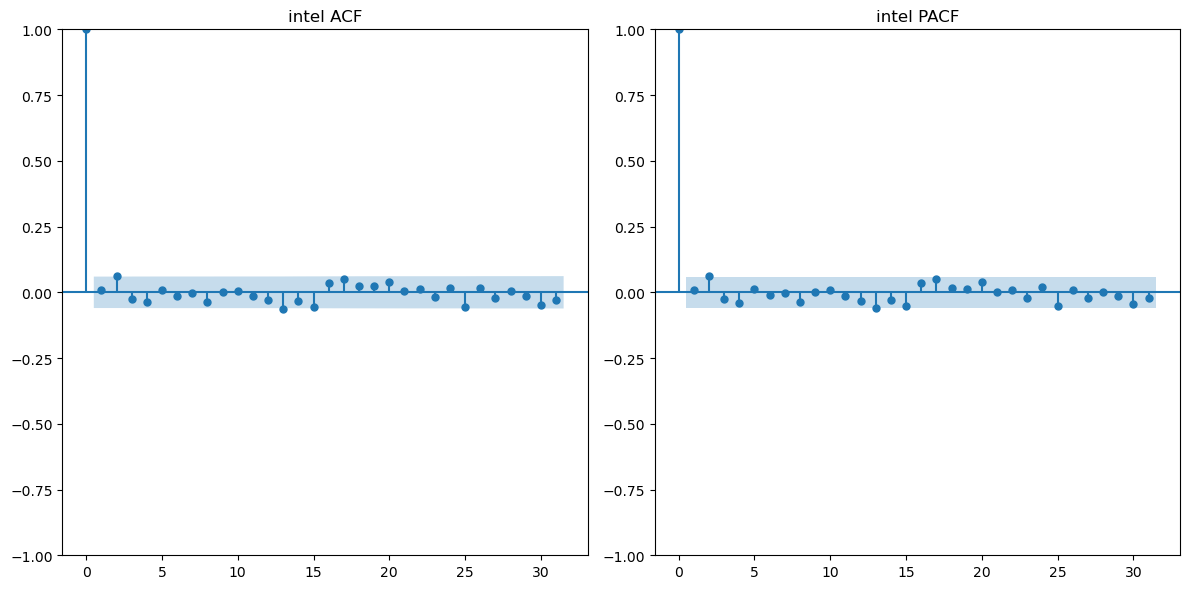

In [17]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # Create only one row with two subplots
plot_acf(intel_data['Log_Diff'].dropna(), ax=axes[0], title="intel ACF")
plot_pacf(intel_data['Log_Diff'].dropna(), ax=axes[1], title="intel PACF")
plt.tight_layout()
plt.show()

In [18]:
# Update the train-test split function to include validation
def train_test_validation_split(data, train_ratio=0.7, test_ratio=0.2):
    train_size = int(len(data) * train_ratio)
    test_size = int(len(data) * test_ratio)
    validation_size = len(data) - train_size - test_size

    train = data[:train_size]
    test = data[train_size:train_size + test_size]
    validation = data[train_size + test_size:]

    return train, test, validation

# Apply the updated split function
intel_train, intel_test, intel_validation = train_test_validation_split(intel_data['Log_Price'])

# Print the sizes of each split for verification
print(f"Train size: {len(intel_train)}, Test size: {len(intel_test)}, Validation size: {len(intel_validation)}")

Train size: 753, Test size: 215, Validation size: 108


In [19]:
from pmdarima import auto_arima

In [20]:
# Sử dụng auto_arima để tìm tham số tốt nhất
print("Finding the best ARIMA parameters using auto_arima...")
auto_arima_model = auto_arima(intel_train, 
                              start_p=1, start_q=1,
                              max_p=5, max_q=5,
                              seasonal=False, 
                              trace=True, 
                              error_action='ignore', 
                              suppress_warnings=True, 
                              stepwise=True)


Finding the best ARIMA parameters using auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-3536.889, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-3540.887, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-3538.889, Time=0.05 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-3538.889, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-3542.887, Time=0.04 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.479 seconds


In [21]:
# In tham số tốt nhất
print(f"Best ARIMA order: {auto_arima_model.order}")

Best ARIMA order: (0, 1, 0)


In [22]:
def fit_arima_and_forecast(train, test, validation, order):
        # Train the ARIMA model
        model = ARIMA(train, order=order)
        model_fit = model.fit()

        # Forecast for test and validation sets
        test_forecast = model_fit.forecast(steps=len(test))
        validation_forecast = model_fit.forecast(steps=len(validation), exog=None)

        # Evaluate the model
        test_rmse = np.sqrt(mean_squared_error(test, test_forecast))
        test_mae = mean_absolute_error(test, test_forecast)
        test_mape = np.mean(np.abs((test - test_forecast) / np.abs(test))) * 100

        validation_rmse = np.sqrt(mean_squared_error(validation, validation_forecast))
        validation_mae = mean_absolute_error(validation, validation_forecast)
        validation_mape = np.mean(np.abs((validation - validation_forecast) / np.abs(validation))) * 100

        print("\nEvaluation on Test Set:")
        print(f"Test RMSE: {test_rmse:.4f}")
        print(f"Test MAE: {test_mae:.4f}")
        print(f"Test MAPE: {test_mape:.4f}%")

        print("\nEvaluation on Validation Set:")
        print(f"Validation RMSE: {validation_rmse:.4f}")
        print(f"Validation MAE: {validation_mae:.4f}")
        print(f"Validation MAPE: {validation_mape:.4f}%")

        # Plot the results
        plt.figure(figsize=(14, 7))
        plt.plot(train.index, train, label='Train Data')
        plt.plot(test.index, test, label='Test Data', color='orange')
        plt.plot(test.index, test_forecast, label='Test Forecast', color='green')
        plt.plot(validation.index, validation, label='Validation Data', color='red')
        plt.plot(validation.index, validation_forecast, label='Validation Forecast', color='purple')
        plt.title('ARIMA Model - Actual vs Forecasted')
        plt.xlabel('Date')
        plt.ylabel('Log Price')
        plt.legend()
        plt.show()

        return model_fit, test_forecast, validation_forecast


intel ARIMA Model:

Evaluation on Test Set:
Test RMSE: 0.5594
Test MAE: 0.4765
Test MAPE: nan%

Evaluation on Validation Set:
Validation RMSE: 0.8411
Validation MAE: 0.8353
Validation MAPE: nan%


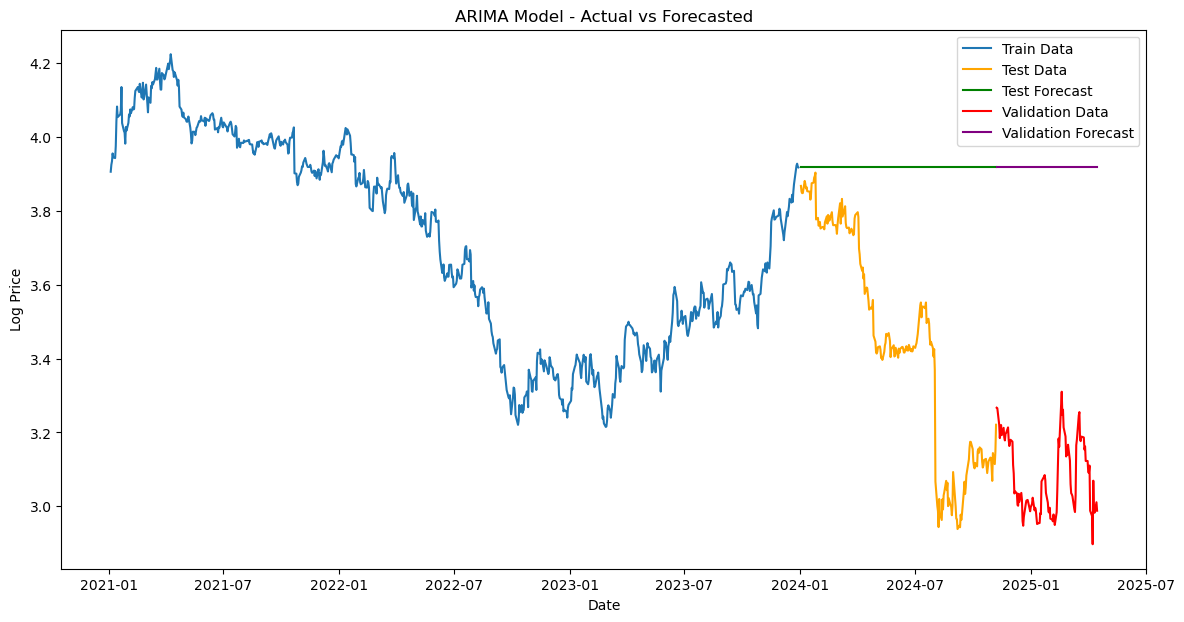

In [23]:
# Apply the updated function
print("\nintel ARIMA Model:")
intel_model, intel_test_forecast, intel_validation_forecast = fit_arima_and_forecast(
        intel_train, intel_test, intel_validation, order=auto_arima_model.order
)

Generating combined forecast plot...


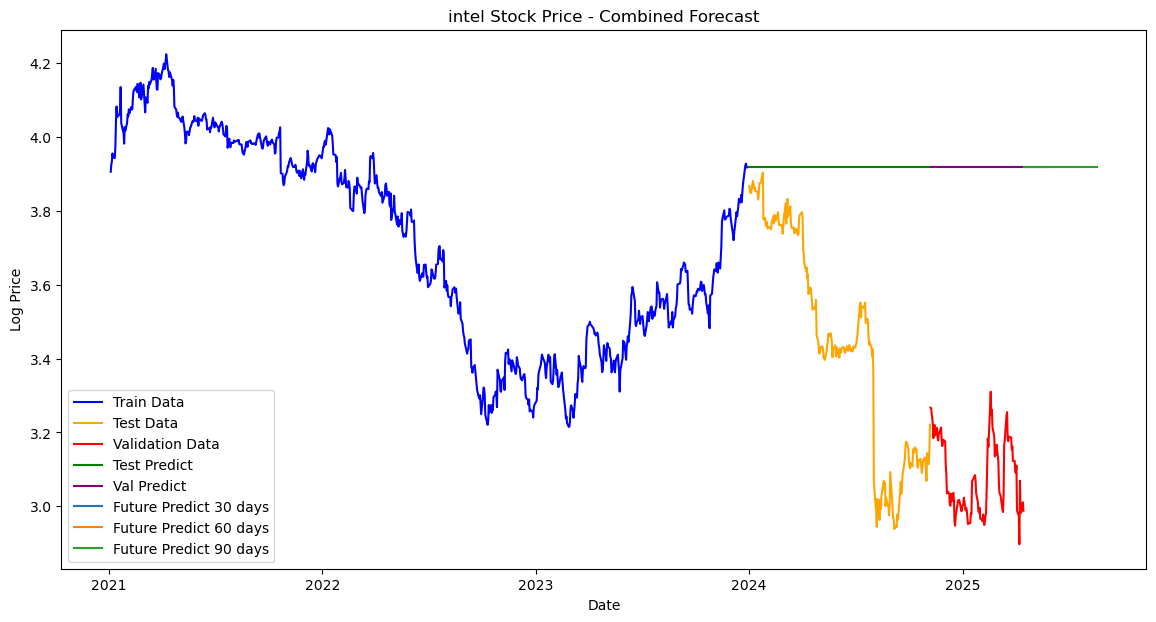

In [24]:
# Combined plot for historical data, test, validation, and future predictions
def plot_combined_forecast(model_fit, train, test, validation, steps_list, title):
    plt.figure(figsize=(14, 7))
    
    # Plot historical data
    plt.plot(train.index, train, label='Train Data', color='blue')
    plt.plot(test.index, test, label='Test Data', color='orange')
    plt.plot(validation.index, validation, label='Validation Data', color='red')
    
    # Plot test and validation forecasts
    test_forecast = model_fit.forecast(steps=len(test))
    validation_forecast = model_fit.forecast(steps=len(validation))
    plt.plot(test.index, test_forecast, label='Test Predict', color='green')
    plt.plot(validation.index, validation_forecast, label='Val Predict', color='purple')
    
    # Generate and plot future forecasts for each step in steps_list
    last_date = validation.index[-1]
    for steps in steps_list:
        future_forecast = model_fit.forecast(steps=steps)
        future_dates = pd.date_range(start=last_date, periods=steps + 1, freq='B')[1:]  # Business days
        plt.plot(future_dates, future_forecast, label=f'Future Predict {steps} days')
    
    # Add labels, title, and legend
    plt.title(f'{title} - Combined Forecast')
    plt.xlabel('Date')
    plt.ylabel('Log Price')
    plt.legend()
    plt.show()

# Call the function to generate the combined plot
print("Generating combined forecast plot...")
plot_combined_forecast(
    model_fit=intel_model,
    train=intel_train,
    test=intel_test,
    validation=intel_validation,
    steps_list=[30, 60, 90],
    title='intel Stock Price'
)